In [7]:
%pip install rank_bm25

Note: you may need to restart the kernel to use updated packages.


In [8]:
from glob import glob

for g in glob(r'C:\Users\ziclp\OneDrive\Desktop\LLM Assignment\1week\PRACTICE1\chap13\2025학년도 서울 학교운동부 운영 계획(매뉴얼)_공문 발송용.pdf'):
    print(g)

C:\Users\ziclp\OneDrive\Desktop\LLM Assignment\1week\PRACTICE1\chap13\2025학년도 서울 학교운동부 운영 계획(매뉴얼)_공문 발송용.pdf


In [9]:
from langchain_community.document_loaders import PyMuPDFLoader  # PyPDFLoader 대신 사용 (표/서식 인식 우수)
from langchain_text_splitters import RecursiveCharacterTextSplitter

def read_pdf_and_split_text(pdf_path, chunk_size=1000, chunk_overlap=200):
    """
    주어진 PDF 파일을 읽고 텍스트를 분할합니다.
    매개변수:
        pdf_path (str): PDF 파일의 경로.
        chunk_size (int, 선택적): 각 텍스트 청크의 크기, 기본값은 300입니다.
        chunk_overlap (int, 선택적): 청크 간의 중첩 크기, 기본값은 100입니다.
    반환값:
        list: 분할된 텍스트 청크의 리스트
    """
    pdf_path= r'C:\Users\ziclp\OneDrive\Desktop\LLM Assignment\1week\PRACTICE1\chap13\2025학년도 서울 학교운동부 운영 계획(매뉴얼)_공문 발송용.pdf'
    
    print(f"PDF: {pdf_path} -------------------------")
    pdf_loader = PyMuPDFLoader(pdf_path)
    data_from_pdf = pdf_loader.load()

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size = chunk_size, chunk_overlap = chunk_overlap
    )

    splits = text_splitter.split_documents(data_from_pdf)

    print(f"Number of splits:{len(splits)}\n")
    return splits

In [10]:
# 벡터 스토어 생성 및 저장 (DB 구축)
import os
import time
from glob import glob
from langchain_chroma import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from dotenv import load_dotenv

# 1. 환경 변수 로드
load_dotenv()
# os.environ["GOOGLE_API_KEY"] = "여기에_키를_직접_입력하거나_env를_사용하세요"

# 2. 임베딩 모델 및 저장 경로 설정
embedding = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")
persist_directory = './chroma_store_gemini_seoul_v1' # 새로운 경로 권장

# 3. 벡터 스토어 생성 로직
if not os.path.exists(persist_directory):
    print(f"🚀 '{persist_directory}' 경로에 새로운 벡터 스토어를 생성합니다...")
    
    # PDF 파일 경로 (본인 환경에 맞게 수정)
    pdf_files = glob(r'C:\Users\ziclp\OneDrive\Desktop\LLM Assignment\1week\PRACTICE1\chap13\2025학년도 서울 학교운동부 운영 계획(매뉴얼)_공문 발송용.pdf')
    
    all_chunks = []
    for g in pdf_files:
        # [Cell 3]에서 정의한 read_pdf_and_split_text 함수 호출 (chunk_size=1000)
        chunks = read_pdf_and_split_text(g) 
        all_chunks.extend(chunks)
    
    # 4. 배치 단위로 DB에 저장 (API 제한 고려)
    batch_size = 10
    vectorstore = None
    
    print(f"총 {len(all_chunks)}개의 청크를 저장합니다.")
    
    for i in range(0, len(all_chunks), batch_size):
        batch = all_chunks[i:i+batch_size]
        try:
            if vectorstore is None:
                vectorstore = Chroma.from_documents(
                    documents=batch, 
                    embedding=embedding, 
                    persist_directory=persist_directory
                )
            else:
                vectorstore.add_documents(documents=batch)
                
            print(f"  - 저장 진행률: {i+len(batch)} / {len(all_chunks)} 완료")
            time.sleep(1.5) # 구글 API 사용량 제한 방지 (RPM)
            
        except Exception as e:
            print(f"❌ 오류 발생 (Batch {i}): {e}")
            time.sleep(10) # 오류 시 대기 후 다음 진행 시도
            
    print("✅ 벡터 스토어 생성이 완료되었습니다!")

else:
    print(f"♻️ 이미 존재하는 벡터 스토어를 로드할 준비가 되었습니다: {persist_directory}")

♻️ 이미 존재하는 벡터 스토어를 로드할 준비가 되었습니다: ./chroma_store_gemini_seoul_v1


In [11]:
import os
import time
from glob import glob
from langchain_chroma import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_core.documents import Document # 문서 객체 복원을 위해 필요
from dotenv import load_dotenv

# 1. 환경 변수 로드
load_dotenv()
# os.environ["GOOGLE_API_KEY"] = "여기에_키를_직접_입력"

# 2. 임베딩 모델 및 저장 경로 설정
embedding = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")
persist_directory = './chroma_store_gemini_seoul_v1'

# ---------------------------------------------------------
# 3. 벡터 스토어 생성 또는 로드 로직 (핵심 수정 부분)
# ---------------------------------------------------------

# 전역 변수 초기화
vectorstore = None
all_chunks = []

# (A) 이미 DB가 존재하는 경우: 로드(Load) 및 청크 복원
if os.path.exists(persist_directory) and os.listdir(persist_directory):
    print(f"♻️ '{persist_directory}'에서 기존 벡터 스토어를 로드합니다...")
    
    # 1. DB 연결
    vectorstore = Chroma(
        persist_directory=persist_directory,
        embedding_function=embedding
    )
    
    # 2. [중요] 저장된 데이터에서 all_chunks 리스트 복원하기!
    #    (이 부분이 없으면 나중에 BM25 검색기 만들 때 에러 발생)
    print("   ↳ 저장된 문서 데이터를 메모리로 불러오는 중...")
    existing_data = vectorstore.get() # DB의 모든 데이터 가져오기
    
    # 텍스트(documents)와 메타데이터(metadatas)를 짝지어서 Document 객체로 다시 만듦
    for content, meta in zip(existing_data['documents'], existing_data['metadatas']):
        all_chunks.append(Document(page_content=content, metadata=meta))
        
    print(f"✅ 복원 완료! 총 {len(all_chunks)}개의 청크를 로드했습니다.")

# (B) DB가 없는 경우: 새로 생성(Create)
else:
    print(f"🚀 '{persist_directory}' 경로에 새로운 벡터 스토어를 생성합니다...")
    
    # PDF 파일 경로 (본인 환경에 맞게 수정)
    # 예: pdf_files = glob('데이터폴더/*.pdf') 
    # 여기서는 예시 파일명 사용
    target_pdf = r'2025학년도 서울 학교운동부 운영 계획(매뉴얼)_공문 발송용.pdf'
    
    if not os.path.exists(target_pdf):
        print(f"❌ 경고: 파일이 없습니다 ({target_pdf}). 경로를 확인하세요.")
    else:
        # [이전 셀]에서 정의한 read_pdf_and_split_text 함수가 있다고 가정
        # 만약 함수가 없다면 PyMuPDFLoader 등을 여기서 직접 써야 함
        chunks = read_pdf_and_split_text(target_pdf) 
        all_chunks.extend(chunks)
    
        # 4. 배치 단위로 DB에 저장 (API 제한 고려)
        batch_size = 10
        print(f"총 {len(all_chunks)}개의 청크를 저장합니다.")
        
        for i in range(0, len(all_chunks), batch_size):
            batch = all_chunks[i:i+batch_size]
            try:
                if vectorstore is None:
                    vectorstore = Chroma.from_documents(
                        documents=batch, 
                        embedding=embedding, 
                        persist_directory=persist_directory
                    )
                else:
                    vectorstore.add_documents(documents=batch)
                    
                print(f"   - 저장 진행률: {min(i+batch_size, len(all_chunks))} / {len(all_chunks)} 완료")
                time.sleep(1.5) # 구글 API 사용량 제한 방지
                
            except Exception as e:
                print(f"❌ 오류 발생 (Batch {i}): {e}")
                time.sleep(10) 
                
        print("✅ 벡터 스토어 생성이 완료되었습니다!")

♻️ './chroma_store_gemini_seoul_v1'에서 기존 벡터 스토어를 로드합니다...
   ↳ 저장된 문서 데이터를 메모리로 불러오는 중...
✅ 복원 완료! 총 439개의 청크를 로드했습니다.


In [12]:
# 목적: '전지훈련' 관련 내용(38~40쪽)이 실제로 검색되는지 확인(앙상블모델과 벡터데이터베이스 활용)
import os
from dotenv import load_dotenv
from langchain_community.vectorstores import Chroma
from langchain_community.retrievers import BM25Retriever
from langchain_core.runnables import RunnableParallel, RunnableLambda

# 🔹 임베딩 모델 (이미 위에서 import 했다면 중복 선언은 빼도 됩니다)
from langchain_google_genai import GoogleGenerativeAIEmbeddings


# 0. 환경 변수 로드
load_dotenv()
# os.environ["GOOGLE_API_KEY"] = "여기에_키를_직접_입력하거나_env를_사용하세요"

# 1. 저장된 벡터 스토어 불러오기
persist_directory = './chroma_store_gemini_seoul_v1'
embedding = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

if os.path.exists(persist_directory):
    vectorstore = Chroma(
        persist_directory=persist_directory,
        embedding_function=embedding
    )

    # ==============================================================
    # 2. 앙상블 검색기 설정 (BM25 + Vector)
    #    - BM25: 단어 기반 키워드 검색
    #    - Vector: 의미(임베딩) 기반 검색
    # ==============================================================

    # BM25용 원문 조각 가져오기 (노트북에서 만든 splits / all_chunks 활용)
    target_docs = None
    if 'all_chunks' in globals():
        target_docs = all_chunks
    elif 'splits' in globals():
        target_docs = splits

    if target_docs:
        # (1) 키워드 검색기 (BM25)
        bm25_retriever = BM25Retriever.from_documents(target_docs)
        bm25_retriever.k = 25  # 키워드 기준으로 넉넉히 25개

        # (2) 의미 검색기 (Vector)
        chroma_retriever = vectorstore.as_retriever(search_kwargs={"k": 25})

        # (3) 앙상블: 두 retriever를 병렬 실행 후 결과 리스트 병합
        retriever = (
            RunnableParallel(
                bm25=bm25_retriever,
                vector=chroma_retriever,
            )
            | RunnableLambda(lambda results: results["bm25"] + results["vector"])
            # 필요하면 여기에서 중복 제거·정렬 로직 추가 가능
        )
        print("✅ 앙상블 검색기(BM25 + Vector, LCEL) 설정 완료!")
    else:
        # BM25용 원문이 없으면 기존 Vector 검색만 사용
        print("⚠️ 'splits' / 'all_chunks' 변수를 찾지 못해 Vector 검색기만 사용합니다.")
        retriever = vectorstore.as_retriever(search_kwargs={"k": 50})

    # 3. 테스트 질문 입력
    query = "운동부 전지훈련"
    print(f"🔍 질문: '{query}'\n" + "="*60)

    # 4. 검색 실행
    chunks = retriever.invoke(query)

    # 5. 결과 확인 (페이지 번호 보정 및 내용 미리보기)
    found_target = False
    for i, chunk in enumerate(chunks):
        # PyMuPDFLoader는 page가 0부터 시작하므로 +1 보정
        page_num = chunk.metadata.get('page', -1) + 1
        filename = chunk.metadata.get('source', 'Unknown').split('\\')[-1]

        # 내용 미리보기 (줄바꿈 제거하여 한 줄로)
        preview = chunk.page_content[:200].replace('\n', ' ')

        print(f"[{i+1}순위] 페이지: {page_num}쪽 | 파일: {filename}")
        print(f"내용: {preview}...\n")

        # 38~40페이지가 나오면 체크
        if 38 <= page_num <= 40:
            found_target = True

    print("="*60)
    if found_target:
        print("✅ 성공! 검색 결과에 '전지훈련 계획(38~40쪽)'이 포함되어 있습니다.")
    else:
        print("❌ 실패. 전지훈련 내용이 검색되지 않았습니다. k값, chunk_size, chunk_overlap 등을 점검해 보세요.")

else:
    print("⚠️ 저장된 벡터 스토어가 없습니다. [PDF 로드 + Chroma 저장] 셀을 먼저 실행해주세요.")


✅ 앙상블 검색기(BM25 + Vector, LCEL) 설정 완료!
🔍 질문: '운동부 전지훈련'


C:\Users\ziclp\AppData\Local\Temp\ipykernel_5436\2327773786.py:21: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the `langchain-chroma package and should be used instead. To use it run `pip install -U `langchain-chroma` and import as `from `langchain_chroma import Chroma``.
  vectorstore = Chroma(


[1순위] 페이지: 39쪽 | 파일: 2025학년도 서울 학교운동부 운영 계획(매뉴얼)_공문 발송용.pdf
내용: 확인된 학교운동부지도자는 향후 3개 학년도 동안 해당 학교운동부 전지훈련 동행 불가)       ‌국내·외 전지훈련 계획 시 필수 검토 사항 구분 내용 비고 예산집행 절차의  투명성 확보 •‌총소요경비 2천만원 초과~5천만 이하일 경우 G2B를 이용  하여 2개 업체 이상 전자견적을 받아 개찰 후 전자계약 체결 •‌전자견적 시 우량 및 허가업체가 입찰...

[2순위] 페이지: 114쪽 | 파일: 2025학년도 서울 학교운동부 운영 계획(매뉴얼)_공문 발송용.pdf
내용: - ‌ 원칙 건마다 예산 계획(수익자부담금 결정)을 수립하여 학부모 전체 동의 후 학교운영위원회 심의 ※ ‌단, 연초에 대회출전비 등을 모두 고려하여 월 수익자부담금을 결정한 후 고정적인 비용을 납입한 경우, 건마다 학부모  전체 동의 및 학교운영위원회 심의 필요 없음(학부모 최초 동의 시 모든 내용을 포함하여 동의한 것으로 간주) ※ 사정에 따라 월 ...

[3순위] 페이지: 39쪽 | 파일: 2025학년도 서울 학교운동부 운영 계획(매뉴얼)_공문 발송용.pdf
내용: 39 학 교 운 동 부   운 영 · 관 리   선 진 화 3 ‌전지훈련 운영 절차  ※ 학부모 동의 및 사전답사는 「서울특별시교육청 수련활동·소규모테마형교육여행 매뉴얼(운영계획)」 참고  학부모  무기명  투표 ✽  (찬반   조사) ▶ 기본계획(안)  •‌학교장 검토 •‌학부모 동의  (동의서 첨부) ▶ 사 전 답 사 ▶ 국내 전지 훈련 학교장 세...

[4순위] 페이지: 38쪽 | 파일: 2025학년도 서울 학교운동부 운영 계획(매뉴얼)_공문 발송용.pdf
내용: - (실시권고기준) 학기중(수업일)을 제외한 방학 기간 중 실시 및 기준 준수 •해당 학년도별 국내·외 전지훈련 실시 가능 총 일수: 30일 내외   ※ 교육청 검토 승인 과정에서 훈련일정, 학부모부담경비 등에 대한 조정  등이 

In [13]:
# 목적: '전지훈련' 관련 내용(38~40쪽)이 실제로 검색되는지 확인 (BM25 + Vector 가중치 앙상블 + 중복 제거 + rerank)
import os
from dotenv import load_dotenv
from langchain_community.vectorstores import Chroma
from langchain_community.retrievers import BM25Retriever
from langchain_core.runnables import RunnableParallel, RunnableLambda
from langchain_google_genai import GoogleGenerativeAIEmbeddings
load_dotenv()

# ─────────────────────────────────────────────
# 0. 가중치 / 최종 개수 설정
# ─────────────────────────────────────────────
BM25_WEIGHT = 0.7       # 키워드 검색 비중
VECTOR_WEIGHT = 0.3     # 의미 검색 비중
FINAL_TOP_K = 30        # 최종 상위 몇 개까지 사용할지


def weighted_merge_and_rerank(results,
                              bm25_weight: float = BM25_WEIGHT,
                              vector_weight: float = VECTOR_WEIGHT,
                              top_k: int = FINAL_TOP_K):
    """
    results: RunnableParallel 출력
      {
        "bm25":  [Document, ...],
        "vector": [Document, ...]
      }

    1) bm25, vector 각각 순위 기반 점수 부여 (1/(rank+1))
    2) 가중치 곱해서 점수 합산
    3) (source, page, content 앞부분) 기준으로 중복 문서 통합
    4) 점수 기준으로 내림차순 정렬
    5) 최종 상위 top_k개 Document만 반환
    """
    bm25_docs = results["bm25"]
    vector_docs = results["vector"]

    scored = []

    # ① BM25 결과 점수
    for rank, doc in enumerate(bm25_docs):
        score = bm25_weight * (1.0 / (rank + 1))  # 1위: 1.0, 2위: 0.5, ...
        scored.append((doc, score))

    # ② Vector 결과 점수
    for rank, doc in enumerate(vector_docs):
        score = vector_weight * (1.0 / (rank + 1))
        scored.append((doc, score))

    # ③ 문서별 점수 합산 + 중복 제거
    merged_scores = {}
    doc_map = {}

    for doc, score in scored:
        key = (
            doc.metadata.get("source", ""),
            doc.metadata.get("page", -1),
            doc.page_content[:80],  # 앞부분 일부만 키로 사용 (중복 구분용)
        )
        merged_scores[key] = merged_scores.get(key, 0.0) + score
        # 최초 등장 문서를 저장 (나중에 그대로 반환)
        if key not in doc_map:
            doc_map[key] = doc

    # ④ 점수 내림차순 정렬
    sorted_items = sorted(merged_scores.items(), key=lambda x: x[1], reverse=True)

    # ⑤ 상위 top_k개만 Document로 변환
    final_docs = [doc_map[key] for key, _ in sorted_items[:top_k]]
    return final_docs


# 1. 저장된 벡터 스토어 불러오기
persist_directory = './chroma_store_gemini_seoul_v1'
embedding = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

if os.path.exists(persist_directory):
    vectorstore = Chroma(
        persist_directory=persist_directory,
        embedding_function=embedding
    )

    # ─────────────────────────────────────────────
    # 2. 리트리버 설정 (BM25 + Vector)
    # ─────────────────────────────────────────────
    target_docs = None
    if 'all_chunks' in globals():
        target_docs = all_chunks
    elif 'splits' in globals():
        target_docs = splits

    if target_docs:
        # (1) BM25 리트리버 (키워드)
        bm25_retriever = BM25Retriever.from_documents(target_docs)
        bm25_retriever.k = 25  # 각 리트리버에서 먼저 뽑아올 개수

        # (2) Vector 리트리버 (의미)
        chroma_retriever = vectorstore.as_retriever(search_kwargs={"k": 25})

        # (3) Parallel → weighted_merge_and_rerank 로 최종 rerank
        retriever = (
            RunnableParallel(
                bm25=bm25_retriever,
                vector=chroma_retriever,
            )
            | RunnableLambda(weighted_merge_and_rerank)
        )
        print("✅ BM25 + Vector 가중치 앙상블 + 중복 제거 + rerank 리트리버 설정 완료!")
    else:
        print("⚠️ 'splits' / 'all_chunks' 변수를 찾지 못해 Vector 리트리버만 사용합니다.")
        retriever = vectorstore.as_retriever(search_kwargs={"k": FINAL_TOP_K})

    # 3. 테스트 질문
    query = "운동부 전지훈련"
    print(f"🔍 질문: '{query}'\n" + "="*60)

    # 4. 검색 실행 (최종 rerank된 결과)
    chunks = retriever.invoke(query)

    # 5. 결과 확인
    found_target = False
    for i, chunk in enumerate(chunks):
        page_num = chunk.metadata.get('page', -1) + 1  # 0-index → 1-index
        filename = chunk.metadata.get('source', 'Unknown').split('\\')[-1]
        preview = chunk.page_content[:200].replace('\n', ' ')

        print(f"[{i+1}순위] 페이지: {page_num}쪽 | 파일: {filename}")
        print(f"내용: {preview}...\n")

        if 38 <= page_num <= 40:
            found_target = True

    print("="*60)
    if found_target:
        print("✅ 성공! 검색 결과에 '전지훈련 계획(38~40쪽)'이 포함되어 있습니다.")
    else:
        print("❌ 실패. 전지훈련 내용이 검색되지 않았습니다. BM25_WEIGHT / VECTOR_WEIGHT, k값, chunk_size 등을 점검해 보세요.")
else:
    print("⚠️ 저장된 벡터 스토어가 없습니다. [PDF 로드 + Chroma 저장] 셀을 먼저 실행해주세요.")


✅ BM25 + Vector 가중치 앙상블 + 중복 제거 + rerank 리트리버 설정 완료!
🔍 질문: '운동부 전지훈련'
[1순위] 페이지: 39쪽 | 파일: 2025학년도 서울 학교운동부 운영 계획(매뉴얼)_공문 발송용.pdf
내용: 확인된 학교운동부지도자는 향후 3개 학년도 동안 해당 학교운동부 전지훈련 동행 불가)       ‌국내·외 전지훈련 계획 시 필수 검토 사항 구분 내용 비고 예산집행 절차의  투명성 확보 •‌총소요경비 2천만원 초과~5천만 이하일 경우 G2B를 이용  하여 2개 업체 이상 전자견적을 받아 개찰 후 전자계약 체결 •‌전자견적 시 우량 및 허가업체가 입찰...

[2순위] 페이지: 114쪽 | 파일: 2025학년도 서울 학교운동부 운영 계획(매뉴얼)_공문 발송용.pdf
내용: - ‌ 원칙 건마다 예산 계획(수익자부담금 결정)을 수립하여 학부모 전체 동의 후 학교운영위원회 심의 ※ ‌단, 연초에 대회출전비 등을 모두 고려하여 월 수익자부담금을 결정한 후 고정적인 비용을 납입한 경우, 건마다 학부모  전체 동의 및 학교운영위원회 심의 필요 없음(학부모 최초 동의 시 모든 내용을 포함하여 동의한 것으로 간주) ※ 사정에 따라 월 ...

[3순위] 페이지: 241쪽 | 파일: 2025학년도 서울 학교운동부 운영 계획(매뉴얼)_공문 발송용.pdf
내용: 241 참 고 자 료 [학교운동부 훈련일지 레포트] ⇢ ‌[업무지원] 학교운동부 지도교사·지도자가 업무지원(외부서비스)에서 등록 및 저장한 훈련일지 정보가 조회됨. 활용하기...

[4순위] 페이지: 39쪽 | 파일: 2025학년도 서울 학교운동부 운영 계획(매뉴얼)_공문 발송용.pdf
내용: 39 학 교 운 동 부   운 영 · 관 리   선 진 화 3 ‌전지훈련 운영 절차  ※ 학부모 동의 및 사전답사는 「서울특별시교육청 수련활동·소규모테마형교육여행 매뉴얼(운영계획)」 참고  학부모  무기명  투표 ✽  (찬반   조사) ▶ 기본계획(안)  •‌학교장 검토 •‌학부모

In [14]:
# 목적: '전지훈련' 관련 내용(38~40쪽)이 LLM rerank까지 포함했을 때 잘 검색되는지 확인(GEMINI RERANK 활용)
import os
import re

from dotenv import load_dotenv

from langchain_community.vectorstores import Chroma
from langchain_community.retrievers import BM25Retriever
from langchain_core.runnables import RunnableParallel, RunnableLambda, RunnablePassthrough
from langchain_core.documents import Document

from langchain_google_genai import (
    GoogleGenerativeAIEmbeddings,
    ChatGoogleGenerativeAI,
)

# ─────────────────────────────────────────────
# 0. 환경 변수 로드 + LLM/임베딩 설정
# ─────────────────────────────────────────────
load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
if not GOOGLE_API_KEY:
    raise ValueError("GOOGLE_API_KEY 환경 변수가 설정되어 있지 않습니다. .env를 확인하세요.")

embedding = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

chat = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",   # rerank에는 flash도 충분
    api_key=GOOGLE_API_KEY,
    temperature=0,
    max_retries=0,
)

# ─────────────────────────────────────────────
# 1. LLM reranker 함수 정의
# ─────────────────────────────────────────────
BM25_WEIGHT = 0.7
VECTOR_WEIGHT = 0.3
FIRST_STAGE_K = 20     # BM25/Vector 각각에서 가져올 개수
FINAL_TOP_K = 20       # 최종 rerank 후 남길 개수

def gemini_rerank(inputs):
    """
    inputs: {
      "query": str,
      "docs": List[Document]
    }
    출력: LLM이 점수 매긴 뒤, 점수 순으로 정렬된 List[Document]
    """
    query = inputs["query"]
    docs = inputs["docs"]

    if not docs:
        return []

    # ① Gemini에 넘길 프롬프트 구성
    prompt_parts = []
    prompt_parts.append(
        "당신은 검색 결과 재정렬(rerank)을 수행하는 모델입니다.\n"
        "사용자의 질문과 여러 개의 문서 후보가 주어집니다.\n"
        "각 문서가 질문과 얼마나 관련 있는지 0에서 100 사이의 점수로 평가하세요.\n"
        "점수는 클수록 더 관련이 높음을 의미합니다.\n\n"
        "출력 형식은 반드시 다음 규칙을 지키세요:\n"
        "- 각 줄에 'index score' 형식으로만 출력 (예: `0 87`)\n"
        "- index는 정수, score는 0~100 정수\n"
        "- 추가 설명, 문장, 불필요한 텍스트는 쓰지 마세요.\n"
    )

    prompt_parts.append(f"\n[질문]\n{query}\n")

    prompt_parts.append("\n[문서 후보들]\n")
    for idx, doc in enumerate(docs):
        preview = doc.page_content[:500].replace("\n", " ")
        prompt_parts.append(f"[{idx}] {preview}\n")

    full_prompt = "\n".join(prompt_parts)

    # ② Gemini에게 요청
    response = chat.invoke(full_prompt)
    text = response.content.strip()

    # ③ "index score" 형식 파싱
    scores = {}
    for line in text.splitlines():
        line = line.strip()
        if not line:
            continue
        # 정규식으로 "숫자 숫자" 형태만 파싱
        m = re.match(r"^(\d+)\s+(\d+)$", line)
        if not m:
            continue
        idx = int(m.group(1))
        score = int(m.group(2))
        if 0 <= idx < len(docs):
            scores[idx] = score

    # 점수 없는 문서는 0점 처리
    ranked = []
    for idx, doc in enumerate(docs):
        score = scores.get(idx, 0)
        ranked.append((doc, score))

    # 점수 기준 내림차순 정렬
    ranked.sort(key=lambda x: x[1], reverse=True)

    # 최종 상위 FINAL_TOP_K개만 사용
    final_docs = [doc for doc, _ in ranked[:FINAL_TOP_K]]
    return final_docs

# ─────────────────────────────────────────────
# 2. 1차 BM25 + Vector 앙상블 (간단 가중치 + 중복 제거)
# ─────────────────────────────────────────────
def first_stage_merge(results,
                      bm25_weight: float = BM25_WEIGHT,
                      vector_weight: float = VECTOR_WEIGHT,
                      top_k: int = FIRST_STAGE_K * 2):
    """
    BM25/Vector 1차 앙상블:
      - 각 결과 리스트 순위 기반 점수 1/(rank+1)
      - 가중치 곱해 합산
      - (source, page, 내용 일부) 기준으로 중복 제거
      - 점수 기준 정렬 후 상위 top_k개 반환
    """
    bm25_docs = results["bm25"]
    vector_docs = results["vector"]

    scored = []

    for rank, doc in enumerate(bm25_docs):
        score = bm25_weight * (1.0 / (rank + 1))
        scored.append((doc, score))

    for rank, doc in enumerate(vector_docs):
        score = vector_weight * (1.0 / (rank + 1))
        scored.append((doc, score))

    merged_scores = {}
    doc_map = {}

    for doc, score in scored:
        key = (
            doc.metadata.get("source", ""),
            doc.metadata.get("page", -1),
            doc.page_content[:80],
        )
        merged_scores[key] = merged_scores.get(key, 0.0) + score
        if key not in doc_map:
            doc_map[key] = doc

    sorted_items = sorted(merged_scores.items(), key=lambda x: x[1], reverse=True)
    final_docs = [doc_map[key] for key, _ in sorted_items[:top_k]]
    return final_docs

# ─────────────────────────────────────────────
# 3. 벡터 스토어 불러오기 + 전체 retriever 구성
# ─────────────────────────────────────────────
persist_directory = "./chroma_store_gemini_seoul_v1"

if os.path.exists(persist_directory):
    vectorstore = Chroma(
        persist_directory=persist_directory,
        embedding_function=embedding,
    )

    # BM25용 청크
    target_docs = None
    if "all_chunks" in globals():
        target_docs = all_chunks
    elif "splits" in globals():
        target_docs = splits

    if target_docs:
        bm25_retriever = BM25Retriever.from_documents(target_docs)
        bm25_retriever.k = FIRST_STAGE_K

        chroma_retriever = vectorstore.as_retriever(
            search_kwargs={"k": FIRST_STAGE_K}
        )

        # 1차: BM25 + Vector 앙상블
        first_stage_retriever = (
            RunnableParallel(
                bm25=bm25_retriever,
                vector=chroma_retriever,
            )
            | RunnableLambda(first_stage_merge)
        )

        # 2차: Gemini LLM rerank
        retriever = (
            {
                "query": RunnablePassthrough(),     # 그대로 넘김
                "docs": first_stage_retriever,      # 1차 후보 문서들
            }
            | RunnableLambda(gemini_rerank)         # LLM으로 재정렬
        )

        print("✅ BM25 + Vector 1차 앙상블 + Gemini LLM rerank 리트리버 설정 완료!")
    else:
        print("⚠️ 'splits' / 'all_chunks' 변수를 찾지 못해 Vector 리트리버만 사용합니다.")
        # 그래도 LLM rerank는 적용해 봄
        base_retriever = vectorstore.as_retriever(
            search_kwargs={"k": FIRST_STAGE_K * 2}
        )

        retriever = (
            {
                "query": RunnablePassthrough(),
                "docs": base_retriever,
            }
            | RunnableLambda(gemini_rerank)
        )

    # ─────────────────────────────────────────────
    # 4. 테스트: '운동부 전지훈련' 검색 및 38~40쪽 포함 여부 확인
    # ─────────────────────────────────────────────
    query = "운동부 전지훈련"
    print(f"🔍 질문: '{query}'\n" + "=" * 60)

    chunks = retriever.invoke(query)

    found_target = False
    for i, chunk in enumerate(chunks):
        page_num = chunk.metadata.get("page", -1) + 1
        filename = chunk.metadata.get("source", "Unknown").split("\\")[-1]
        preview = chunk.page_content[:200].replace("\n", " ")

        print(f"[{i+1}순위] 페이지: {page_num}쪽 | 파일: {filename}")
        print(f"내용: {preview}...\n")

        if 38 <= page_num <= 40:
            found_target = True

    print("=" * 60)
    if found_target:
        print("✅ 성공! LLM rerank 결과에 '전지훈련 계획(38~40쪽)'이 포함되어 있습니다.")
    else:
        print("❌ 실패. 전지훈련 내용이 검색되지 않았습니다. FIRST_STAGE_K, FINAL_TOP_K, 가중치 등을 조정해 보세요.")
else:
    print("⚠️ 저장된 벡터 스토어가 없습니다. [PDF 로드 + Chroma 저장] 셀을 먼저 실행해주세요.")


✅ BM25 + Vector 1차 앙상블 + Gemini LLM rerank 리트리버 설정 완료!
🔍 질문: '운동부 전지훈련'
[1순위] 페이지: 39쪽 | 파일: 2025학년도 서울 학교운동부 운영 계획(매뉴얼)_공문 발송용.pdf
내용: 39 학 교 운 동 부   운 영 · 관 리   선 진 화 3 ‌전지훈련 운영 절차  ※ 학부모 동의 및 사전답사는 「서울특별시교육청 수련활동·소규모테마형교육여행 매뉴얼(운영계획)」 참고  학부모  무기명  투표 ✽  (찬반   조사) ▶ 기본계획(안)  •‌학교장 검토 •‌학부모 동의  (동의서 첨부) ▶ 사 전 답 사 ▶ 국내 전지 훈련 학교장 세...

[2순위] 페이지: 38쪽 | 파일: 2025학년도 서울 학교운동부 운영 계획(매뉴얼)_공문 발송용.pdf
내용: 38 2 0 2 5 학 년 도   서 울   학 교 운 동 부   운 영   매 뉴 얼 학교운동부 국내·외 전지훈련 ‌전지훈련의 개념 - ‌전지훈련이란, 「학교체육진흥법」에 따른 학생선수가 「국민체육진흥법」상 체육가맹단체 주관 공식 대회 이외의  모든 숙박형 훈련에 참가하는 것을 의미하며, 학교체육진흥법 시행규칙 제6조의2에서 정의하는 교육부령으로  정...

[3순위] 페이지: 39쪽 | 파일: 2025학년도 서울 학교운동부 운영 계획(매뉴얼)_공문 발송용.pdf
내용: 확인된 학교운동부지도자는 향후 3개 학년도 동안 해당 학교운동부 전지훈련 동행 불가)       ‌국내·외 전지훈련 계획 시 필수 검토 사항 구분 내용 비고 예산집행 절차의  투명성 확보 •‌총소요경비 2천만원 초과~5천만 이하일 경우 G2B를 이용  하여 2개 업체 이상 전자견적을 받아 개찰 후 전자계약 체결 •‌전자견적 시 우량 및 허가업체가 입찰...

[4순위] 페이지: 38쪽 | 파일: 2025학년도 서울 학교운동부 운영 계획(매뉴얼)_공문 발송용.pdf
내용: - (실시권고기준) 학기중(수업일)을 제외한 방학 기간 중 실시 및 기준 준수 •해당 학년도별 국내·외

In [15]:
import os
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

# 1. LLM 설정 (사용자님 코드 유지)
chat = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash", # 최신 모델 권장 (또는 gemini-2.5-flash)
    api_key= GOOGLE_API_KEY,
    temperature=0,
    max_retries=0,
)

In [16]:
# Router 설정
from langchain_core.prompts import ChatPromptTemplate
from typing import Literal # 문자열 리터럴 타입을 지원하는 typing 모듈의 클래스
from pydantic import BaseModel, Field

# Data model
class RouteQuery(BaseModel):
    """사용자 쿼리를 가장 관련성이 높은 데이터 소스로 라우팅합니다."""
    
    datasource: Literal["vectorstore", "casual_talk"] = Field(
        ...,
        description="""
        사용자 질문에 따라 casual_talk 또는 vectorstore로 라우팅합니다.
        - casual_talk: 일상 대화를 위한 데이터 소스. 사용자가 일상적인 질문을 할 때 사용합니다.
        - vectorstore: 사용자 질문에 답하기 위해 RAG로 vectorstore 검색이 필요한 경우 사용합니다.
        """,
    )

In [17]:
# 특정 모델을 structured output (구조화된 출력)과 함께 사용하기 위해 설정
structured_llm_router = chat.with_structured_output(RouteQuery)

router_system = """
당신은 사용자의 질문을 vectorstore 또는 casual_talk으로 라우팅하는 전문가입니다.
- vectorstore에는 인공지능을 활용한 서울특별시 학교 운동부 운영과 관련된 문서가 포함되어 있습니다. 이 주제에 대한 질문에는 vectorstore를 사용하십시오.
- 사용자의 질문이 일상 대화에 관련된 경우 casual_talk을 사용하십시오.
"""

# 시스템 메시지와 사용자의 질문을 포함하는 프롬프트 템플릿 생성
route_prompt = ChatPromptTemplate.from_messages([
    ("system", router_system),
    ("human", "{question}"),
])

# 라우터 프롬프트와 구조화된 출력 모델을 결합한 객체
question_router = route_prompt | structured_llm_router


In [18]:
# ✅ 올바른 호출 방식 (.invoke 사용)
print(
    question_router.invoke({
        "question": "운동부 전지훈련 학교장 체크리스트 ?"
    })
)

print(question_router.invoke({"question": "잘 지냈어?"}))

datasource='vectorstore'
datasource='casual_talk'


In [19]:
from langchain_core.prompts import PromptTemplate

class GradeDocuments(BaseModel):
    """검색된 문서가 질문과 관련성 있는지 yes 또는 no로 평가합니다."""

    binary_score: Literal["yes", "no"] = Field(
        description="문서가 질문과 관련이 있는지 여부를 'yes' 또는 'no'로 평가합니다."
    )

structured_llm_grader = chat.with_structured_output(GradeDocuments)

In [20]:
grader_prompt = PromptTemplate.from_template("""
당신은 검색된 문서가 사용자 질문과 관련이 있는지 평가하는 평가자입니다. \n 
문서에 사용자 질문과 관련된 키워드 또는 의미가 포함되어 있으면, 해당 문서를 관련성이 있다고 평가하십시오. \n
엄격한 테스트가 필요하지 않습니다. 목표는 잘못된 검색 결과를 걸러내는 것입니다. \n
문서가 질문과 관련이 있는지 여부를 나타내기 위해 'yes' 또는 'no'로 이진 점수를 부여하십시오.
                                             
Retrieved document: \n {document} \n\n 
User question: {question}
""")

retrieval_grader = grader_prompt | structured_llm_grader
question = "운동부 전지훈련을 위한 학교장 체크리스트는 뭐야?"
documents = retriever.invoke(question)

for doc in documents:
    print(doc)


page_content='38
2
0
2
5
학
년
도
 
서
울
 
학
교
운
동
부
 
운
영
 
매
뉴
얼
학교운동부 국내·외 전지훈련
‌전지훈련의 개념
- ‌전지훈련이란, 「학교체육진흥법」에 따른 학생선수가 「국민체육진흥법」상 체육가맹단체 주관 공식 대회 이외의 
모든 숙박형 훈련에 참가하는 것을 의미하며, 학교체육진흥법 시행규칙 제6조의2에서 정의하는 교육부령으로 
정하는 공식 경기대회를 참가하지 않는 경우 별도의 전지훈련 계획을 수립하여 실시하여야 함
   
‌기본 원칙
- ‌학생선수 안전 및 학부모 경제적 부담 경감을 위하여 국내·외 전지훈련 지양하되, 학교장이 필요하다고 판단하고 
학부모가 동의하는 경우 방학 기간 중 실시
- 장기간의 국내 전지훈련도 가급적 자제, 학교 및 인근 체육시설 이용
- (임장) 훈련 장소에 학교운동부지도자 임장 지도를 원칙
- (학교장) 안전책임자 지정, 학부모 동의, 수익자 부담 경비 최소화, 학습권 보장
- (사전답사) 숙소 및 훈련장 등의 사전답사 의무적으로 실시(허가된 시설물 이용)
※ 매년 실시하는 장소로 전지훈련을 가더라도 매년 사전 답사 필수
- (선수보호) 식중독 예방, 교통·생활안전,(성)폭력 예방 등 인권 보호 및 안전관리 철저
- (학교운영위원회) 전지훈련은 학교운영위원회에 계획 심의 후 실시
- (훈련계획서) 학부모 동의서, 잔류 학생 지도 계획 포함 학교장 결재 
- (금지사항) 어떠한 경우에도 학부모가 동행하여 역할을 부여하거나 봉사활동 금지
※ 「부정청탁 및 금품등 수수의 금지에 관한 법률」 ‘편의 제공’에 해당
- (실시권고기준) 학기중(수업일)을 제외한 방학 기간 중 실시 및 기준 준수
•해당 학년도별 국내·외 전지훈련 실시 가능 총 일수: 30일 내외  
※ 교육청 검토 승인 과정에서 훈련일정, 학부모부담경비 등에 대한 조정  등이 요청될 수 있음
- 세부 절차 및 유의 사항은 「서울특별시교육청 수련활동·소규모테마형교육여행 매뉴얼(운영계획)」준용' metadata={'creati

In [21]:
import time # 1. 시간 지연 기능을 사용하기 위해 import

filtered_docs = []

print(f"검색된 문서 개수: {len(documents)}")

for i, doc in enumerate(documents):
    print(f"Processing Document {i + 1}...")
    
    # [핵심 수정 사항] API 호출 전 강제로 시간을 끕니다.
    # Gemini 무료 티어 한도(분당 10~15회)를 고려하여 7초 대기
    time.sleep(7) 
    
    try:
        # 평가 실행
        is_relevant = retrieval_grader.invoke({"question": question, "document": doc.page_content})
        
        print(f"  - 관련성 평가 결과: {is_relevant.binary_score}")
        print(f"  - 문서 내용 일부: {doc.page_content[:50]}...") # 내용은 너무 길어서 50자만 출력
        print("=================================\n")

        if is_relevant.binary_score == "yes":
            filtered_docs.append(doc)
            
    except Exception as e:
        print(f"  ❌ Error processing document {i+1}: {e}")
        # 에러가 나도 멈추지 않고 다음 문서로 넘어가도록 처리
        continue

print(f"최종 필터링된 문서 개수: {len(filtered_docs)}")

검색된 문서 개수: 20
Processing Document 1...
  - 관련성 평가 결과: yes
  - 문서 내용 일부: 38
2
0
2
5
학
년
도
 
서
울
 
학
교
운
동
부
 
운
영
 
매
뉴
얼
학...

Processing Document 2...
  - 관련성 평가 결과: yes
  - 문서 내용 일부: - (실시권고기준) 학기중(수업일)을 제외한 방학 기간 중 실시 및 기준 준수
•해당 학년...

Processing Document 3...
  - 관련성 평가 결과: no
  - 문서 내용 일부: 하는 경우 그에 관한 내용, 운동부 폐지·근무 평가 결과 부적격 판단·사업비 부족 등의 재...

Processing Document 4...
  - 관련성 평가 결과: no
  - 문서 내용 일부: 3. 휴게시간 : (예시) 18:00~19:00, ※ 4시간 당 30분씩 휴게시간 보장
②...

Processing Document 5...
  - 관련성 평가 결과: no
  - 문서 내용 일부: 일지를 작성하지 않거나 분실함, 전결 규정에 따른 결재를 받지 않음
⇢  기관 경고 
사례...

Processing Document 6...
  - 관련성 평가 결과: no
  - 문서 내용 일부: 238
2
0
2
5
학
년
도
 
서
울
 
학
교
운
동
부
 
운
영
 
매
뉴
얼
...

Processing Document 7...
  - 관련성 평가 결과: no
  - 문서 내용 일부: 259
참
고
자
료
[기안문상신]
❼ ‌{결재자지정} 버튼을 클릭하여 결재자를 지정함....

Processing Document 8...
  - 관련성 평가 결과: no
  - 문서 내용 일부: 237
참
고
자
료
3. 학교운동부훈련일지관리
1) 학교운동부 훈련일지 등록
[학교운동부...

Processing Document 9...
  - 관련성 평가 결과: yes
  - 문서 내용 일부: 17
학
생
선
수
 
학
습
권
 
보
장
1
기초학

In [22]:
### Generate
# PromptTemplate을 사용하여 RAG를 위한 프롬프트를 생성합니다.

rag_generate_system = """
너는 사용자의 질문에 대해 주어진 context에 기반하여 답변하는 학교 운동부 운영 전문가이다. 
주어진 context는 vectorstore에서 검색된 결과이다. 
주어진 context를 기반으로 사용자의 question에 대해 답변하라.

=================================
question: {question}
context: {context}
"""

# PromptTemplate을 생성하여 question과 context를 포맷팅
rag_prompt = PromptTemplate(
    input_variables=["question", "context"],
    template=rag_generate_system
)

# rag chain
rag_chain = rag_prompt | chat 

# 사용자 질문과 검색된 문서를 입력으로 사용하여 RAG를 실행
question = "운동부 전지훈련을 위한 학교장의 역할"

rag_chain.invoke({"question": question, "context": filtered_docs})


AIMessage(content='학교 운동부 전지훈련을 위한 학교장의 역할은 다음과 같습니다.\n\n1.  **전지훈련 필요성 판단 및 승인**:\n    *   학생선수의 안전과 학부모의 경제적 부담 경감을 위해 국내·외 전지훈련은 지양하는 것이 원칙이나, 학교장이 필요하다고 판단하고 학부모가 동의하는 경우 방학 기간 중 실시를 승인할 수 있습니다.\n    *   학부모 동의서와 잔류 학생 지도 계획이 포함된 훈련계획서에 대해 최종 결재를 해야 합니다.\n\n2.  **안전 및 학습권 보장 책임**:\n    *   전지훈련 시 안전책임자를 지정하여 학생선수의 안전을 최우선으로 확보해야 합니다.\n    *   학생선수의 학습권을 보장해야 하며, 특히 최저학력 미도달 학생선수에게는 기초학력보장 프로그램을 의무적으로 제공하고, 이를 이수한 경우 경기대회 참가를 허용해야 합니다. (최저학력 미이수 시 학교장 확인서 발급 불가)\n\n3.  **재정 및 경비 관리**:\n    *   학부모의 경제적 부담을 최소화하도록 노력해야 합니다.\n    *   학부모 부담 경비 발생 시 지도자 관련 지출은 숙박 및 식비 등 필수경비로만 계획하도록 권장하며, 연장근로수당 등은 지양해야 합니다.\n    *   학교회계 편입 등 관련 법령에서 정한 절차를 준수하여 전지훈련 운영비를 집행해야 합니다.\n    *   학교운동부 운영 경비 집행 내역을 확인하고 승인하는 역할을 합니다.\n\n4.  **계획 수립 및 심의/제출**:\n    *   전지훈련 계획을 수립하고 학교운영위원회에 심의를 요청하여야 합니다.\n    *   국외 전지훈련을 실시할 경우, 학교운영위원회 심의 2개월 전 교육(지원)청에 전지훈련 계획서를 반드시 제출하여 사전 검토를 받아야 합니다.\n    *   국내외 전지훈련에 불참하는 학생선수들에 대한 대책(잔류지도계획 등)을 계획서에 포함하여 결재해야 합니다.', additional_kwargs={}, response_metadata={'prompt

In [23]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    question: str # 사용자 질문
    generation: str # LLM 생성 결과
    documents: List[str] # 검색된 문서

In [24]:
def route_question(state): 
    """
    사용자 질문을 vectorstore 또는 casual_talk로 라우팅합니다.
    """
    print('------ROUTE------')

    question = state['question']
    route = question_router.invoke({"question": question})
    time.sleep(10)

    print(f"---Routing to {route.datasource}---")
    return route.datasource


In [25]:
def retrieve(state): 
    """
    vectorstore에서 질문에 대한 문서를 검색합니다.
    
    Args:
        state (dict): 현재 graph state

    return:
        state (dict): 검색된 문서와 사용자 질문을 포함하는 새로운 graph state
    """
    print('------RETRIEVE------')
    question = state['question']

    # Retrieve documents
    documents = retriever.invoke(question)
    time.sleep(10)
    return {"documents": documents, "question": question}

In [26]:
import time

def grade_documents(state):
    """
    문서가 질문과 관련이 있는지 평가합니다.
    """
    print("---CHECK RELEVANCE---")
    question = state["question"]
    documents = state["documents"]
    
    filtered_docs = []
    
    # [수정] 반복문 안에서 API 호출 간격을 조절합니다.
    for doc in documents:
        # API 호출 전 잠시 대기 (필수!)
        time.sleep(5) 
        
        score = retrieval_grader.invoke({"question": question, "document": doc.page_content})
        grade = score.binary_score
        
        if grade == "yes":
            print("   -> 관련 있음 (Grade: YES)")
            filtered_docs.append(doc)
        else:
            print("   -> 관련 없음 (Grade: NO)")
            
    return {"documents": filtered_docs, "question": question}

In [27]:
import time

def generate(state):
    """
    답변을 생성합니다.
    """
    print("------GENERATE------")
    
    # [추가] API 호출 전 10초 대기 (할당량 초과 방지)
    print("   (API 쿨타임 대기 중... 10초)")
    time.sleep(10) 

    question = state["question"]
    documents = state["documents"]
    
    # 여기서 에러가 났던 것입니다. 이제 10초 쉬었으므로 안전합니다.
    generation = rag_chain.invoke({"question": question, "context": documents})
    
    return {
        "documents": documents,
        "question": question,
        "generation": generation
    }

In [28]:
def casual_talk(state):
    """
    일상 대화를 위한 답변을 생성합니다.

    Args:
        state (dict): 현재 graph state

    return:
        state (dict): 일상 대화 결과와 사용자 질문을 포함하는 새로운 graph state
    """
    print('------CASUAL TALK------')
    question = state['question']
    generation = chat.invoke(question)
    return {
        "question": question,
        "generation": generation
    }

In [29]:
from langgraph.graph import START, StateGraph, END

workflow = StateGraph(GraphState)

In [30]:
nodes_to_add = {
    "retrieve": retrieve,
    "grade_documents": grade_documents,
    "generate": generate,
    "casual_talk": casual_talk
}

for name, fn in nodes_to_add.items():
    if name not in workflow.nodes:
        workflow.add_node(name, fn)


In [31]:
from langgraph.graph import START, StateGraph, END

# 1. 그래프 초기화 (이 부분이 실행될 때마다 그래프가 리셋됨)
workflow = StateGraph(GraphState)

# 2. 노드 추가 (초기화된 그래프에 노드를 다시 추가)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("casual_talk", casual_talk)

# 3. 조건부 엣지(분기) 정의
workflow.add_conditional_edges(
    START, 
    route_question,
    {
        "vectorstore": "retrieve",
        "casual_talk": "casual_talk"
    }
)

# 4. 일반 엣지 연결
workflow.add_edge("casual_talk", END)
workflow.add_edge("retrieve", "grade_documents")
workflow.add_edge("grade_documents", "generate")
workflow.add_edge("generate", END)

# 5. 컴파일
app = workflow.compile()

print("✅ 그래프 빌드 및 컴파일 완료!")

✅ 그래프 빌드 및 컴파일 완료!


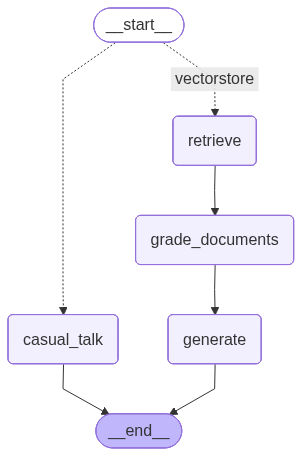

In [32]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    #  실패 시 통과
    pass


In [33]:
inputs = {
    "question": "운동부 전지훈련"
}
app.invoke(inputs) # workflow를 실행합니다.

------ROUTE------
---Routing to vectorstore---
------RETRIEVE------
---CHECK RELEVANCE---
   -> 관련 있음 (Grade: YES)
   -> 관련 있음 (Grade: YES)
   -> 관련 있음 (Grade: YES)
   -> 관련 있음 (Grade: YES)
   -> 관련 있음 (Grade: YES)
   -> 관련 있음 (Grade: YES)
   -> 관련 있음 (Grade: YES)
   -> 관련 있음 (Grade: YES)
   -> 관련 있음 (Grade: YES)
   -> 관련 있음 (Grade: YES)
   -> 관련 있음 (Grade: YES)
   -> 관련 있음 (Grade: YES)
   -> 관련 있음 (Grade: YES)
   -> 관련 있음 (Grade: YES)
   -> 관련 있음 (Grade: YES)
   -> 관련 있음 (Grade: YES)
   -> 관련 있음 (Grade: YES)
   -> 관련 없음 (Grade: NO)
   -> 관련 없음 (Grade: NO)
   -> 관련 없음 (Grade: NO)
------GENERATE------
   (API 쿨타임 대기 중... 10초)


{'question': '운동부 전지훈련',
 'generation': AIMessage(content="학교 운동부 운영 전문가로서, 주어진 context에 기반하여 운동부 전지훈련에 대해 상세히 안내해 드리겠습니다.\n\n---\n\n### 학교 운동부 전지훈련 운영 안내\n\n학교 운동부 전지훈련은 학생선수의 경기력 향상과 역량 강화를 위해 실시될 수 있으나, 학생선수의 안전과 학부모의 경제적 부담 경감을 최우선으로 고려하여 신중하게 추진되어야 합니다.\n\n**1. 전지훈련의 개념 및 기본 원칙**\n*   **개념:** 「학교체육진흥법」에 따른 학생선수가 「국민체육진흥법」상 체육가맹단체 주관 공식 대회 이외의 모든 숙박형 훈련에 참가하는 것을 의미합니다. 공식 경기대회에 참가하지 않는 경우 별도의 전지훈련 계획을 수립하여 실시해야 합니다.\n*   **기본 원칙:**\n    *   국내·외 전지훈련은 가급적 지양하되, 학교장이 필요하다고 판단하고 학부모가 동의하는 경우 방학 기간 중 실시합니다.\n    *   장기간의 국내 전지훈련도 자제하고, 학교 및 인근 체육시설 이용을 권장합니다.\n    *   훈련 장소에는 학교운동부지도자가 임장 지도를 원칙으로 합니다.\n    *   학교장은 안전책임자를 지정하고, 학부모 동의를 받으며, 수익자 부담 경비를 최소화하고 학습권을 보장해야 합니다.\n    *   숙소 및 훈련장 등에 대한 사전답사를 매년 의무적으로 실시해야 합니다.\n    *   식중독 예방, 교통·생활안전, (성)폭력 예방 등 학생선수의 인권 보호 및 안전 관리에 철저를 기해야 합니다.\n    *   전지훈련은 학교운영위원회 심의 후 실시해야 합니다.\n    *   훈련계획서에는 학부모 동의서와 잔류 학생 지도 계획이 포함되어야 합니다.\n    *   어떠한 경우에도 학부모가 동행하여 역할을 부여하거나 봉사활동을 하는 것은 금지됩니다(「부정청탁 및 금품등 수수의 금지에 관한 법률」의 '편의 제공'에 해당).\n    *   해당

In [34]:
inputs={
    "question":"잘 지내고 있어?"
}

app.invoke(inputs)

------ROUTE------
---Routing to casual_talk---
------CASUAL TALK------


{'question': '잘 지내고 있어?',
 'generation': AIMessage(content='네, 잘 지내고 있습니다! 😊\n\n저는 인공지능이라 항상 최상의 상태를 유지하고 있답니다.\n당신은 잘 지내고 계신가요? 별일 없으시죠?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--28ad8c5c-21df-4f9f-bc5c-13edf534eaf0-0', usage_metadata={'input_tokens': 7, 'output_tokens': 456, 'total_tokens': 463, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 410}})}

In [36]:
inputs = {
    "question": "운동부 전지훈련시 학교장의 역할은 뭐야?"
}

for msg, meta in app.stream(inputs, stream_mode='messages'):
    print(msg.content, end='')


------ROUTE------
---Routing to vectorstore---
------RETRIEVE------
16 95
8 90
18 88
20 88
10 85
7 80
11 70
23 65
4 60
32 55
35 55
36 55
0 0
1 0
2 0
3 0
5 0
6 0
9 0
12 0
13 0
14 0
15 0
17 0
19 0
21 0
22 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
33 0
34 0
37 0
38 0
39 0---CHECK RELEVANCE---
   -> 관련 없음 (Grade: NO)
   -> 관련 없음 (Grade: NO)
   -> 관련 없음 (Grade: NO)
   -> 관련 없음 (Grade: NO)
   -> 관련 있음 (Grade: YES)
   -> 관련 없음 (Grade: NO)
   -> 관련 없음 (Grade: NO)
   -> 관련 있음 (Grade: YES)
   -> 관련 없음 (Grade: NO)
   -> 관련 있음 (Grade: YES)
   -> 관련 없음 (Grade: NO)
   -> 관련 없음 (Grade: NO)
   -> 관련 없음 (Grade: NO)
   -> 관련 없음 (Grade: NO)
   -> 관련 없음 (Grade: NO)
   -> 관련 없음 (Grade: NO)
   -> 관련 없음 (Grade: NO)
   -> 관련 없음 (Grade: NO)
   -> 관련 없음 (Grade: NO)
   -> 관련 없음 (Grade: NO)
------GENERATE------
   (API 쿨타임 대기 중... 10초)
학교 운동부 전지훈련 시 학교장의 역할은 다음과 같습니다.

1.  **학생선수 출석 인정 결석 처리:** 학교장은 학생선수가 전지훈련에 참가할 경우, 허용 가능한 범위 내에서 출석 인정 결석 처리를 할 수 있습니다.
2.  **최저학력 확인 및 보장:** 「학교체육진흥법」 제11조에 따라 학생선수의 최저학력을 확인하고 